<a href="https://colab.research.google.com/github/magicaltrap/english_german_translation/blob/master/seq2seq_translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
path_translation = "/content/gdrive/My Drive/data/translation/"
path_translation_data = "/content/gdrive/My Drive/data/translation/data/"

In [0]:
from fastai.text import *

# Methods for creating and loading Databunches

In [0]:
def seq2seq_collate(samples, pad_idx=1, pad_first=True, backwards=False):
    "Function that collect samples and adds padding. Flips token order if needed"
    samples = to_data(samples) #https://docs.fast.ai/torch_core.html#to_data #to their int value?
    max_len_x,max_len_y = max([len(s[0]) for s in samples]),max([len(s[1]) for s in samples]) #max length of a sentence in the dataset
    res_x = torch.zeros(len(samples), max_len_x).long() + pad_idx #samples x max_len of whole data 
    res_y = torch.zeros(len(samples), max_len_y).long() + pad_idx
    if backwards: pad_first = not pad_first
    for i,s in enumerate(samples): #go through every sample
        if pad_first: #padding tokens first then emb
            res_x[i,-len(s[0]):],res_y[i,-len(s[1]):] = LongTensor(s[0]),LongTensor(s[1]) #row 0, 1, 2 (one sentence in each language each)
        else:         
            res_x[i,:len(s[0]):],res_y[i,:len(s[1]):] = LongTensor(s[0]),LongTensor(s[1])
    if backwards: res_x,res_y = res_x.flip(1),res_y.flip(1)
    return res_x,res_y

In [0]:
class Seq2SeqDataBunch(TextDataBunch):
    "Create a `TextDataBunch` suitable for training an RNN classifier."
    @classmethod
    def create(cls, train_ds, valid_ds, test_ds=None, path:PathOrStr='.', bs:int=32, val_bs:int=None, pad_idx=1,
               dl_tfms=None, pad_first=False, device:torch.device=None, no_check:bool=False, backwards:bool=False, **dl_kwargs) -> DataBunch:
        "Function that transform the `datasets` in a `DataBunch` for classification. Passes `**dl_kwargs` on to `DataLoader()`"
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        val_bs = ifnone(val_bs, bs)
        collate_fn = partial(seq2seq_collate, pad_idx=pad_idx, pad_first=pad_first, backwards=backwards)
        train_sampler = SortishSampler(datasets[0].x, key=lambda t: len(datasets[0][t][0].data), bs=bs//2)
        train_dl = DataLoader(datasets[0], batch_size=bs, sampler=train_sampler, drop_last=True, **dl_kwargs)
        dataloaders = [train_dl]
        for ds in datasets[1:]:
            lengths = [len(t) for t in ds.x.items]
            sampler = SortSampler(ds.x, key=lengths.__getitem__)
            dataloaders.append(DataLoader(ds, batch_size=val_bs, sampler=sampler, **dl_kwargs))
        return cls(*dataloaders, path=path, device=device, collate_fn=collate_fn, no_check=no_check)

In [0]:
class Seq2SeqTextList(TextList):
    _bunch = Seq2SeqDataBunch
    _label_cls = TextList

## Load Databunch (137k) and Embeddings

In [0]:
data = load_data(path_translation_data, "db1_137k_25sl")

In [0]:
data.show_batch()

text,target
"xxbos to be sure , substantial progress has been made in the last 15 years , and efforts are being made to sustain it .","xxbos sicherlich wurden in den letzten fünfzehn jahren erhebliche fortschritte gemacht , und die bemühungen gehen weiter ."
"xxbos despite a change of government in the netherlands since voluntary euthanasia was legalized , no effort has been made to repeal the measure .","xxbos trotz eines xxunk in den niederlanden seit der legalisierung der freiwilligen euthanasie , gab es keinerlei bemühungen diese maßnahme aufzuheben ."
"xxbos and now , with the election results inciting the largest protests since the collapse of the soviet union , that hope is growing .","xxbos und jetzt , da das wahlergebnis die größten proteste seit dem zusammenbruch der sowjetunion hervorruft , wächst diese hoffnung noch weiter ."
"xxbos this is a matter of human rights and basic values , and it is vital to peace and cohesion in societies across europe .",xxbos das ist eine frage der menschenrechte und der grundwerte und von entscheidender bedeutung für den frieden und zusammenhalt der gesellschaften in ganz europa .
xxbos so mexico 's auto industry must make huge advances in productivity if it is to maintain the same wage level in the future .,"xxbos wenn man daher in zukunft das einkommensniveau halten will , muss die mexikanische autoindustrie große produktivitätszuwächse aufweisen ."


In [0]:
emb_enc = torch.load(path_translation + 'en_emb_137k_25l.pth')
emb_dec = torch.load(path_translation + 'de_emb_137k_25l.pth')

## Model

### Encoders & Decoders

The model in itself consists in an encoder and a decoder

![Seq2seq model](https://github.com/fastai/course-nlp/blob/master/images/seq2seq.png?raw=1)

<center><i>Diagram from Smerity's <a href="https://smerity.com/articles/2016/google_nmt_arch.html">Peeking into the neural network architecture used for Google's Neural Machine Translation</a></i></center>

The encoder is a recurrent neural net and we feed it our input sentence, producing an output (that we discard for now) and a hidden state.  A **hidden state** is the activations that come out of an RNN.

That hidden state is then given to the decoder (an other RNN) which uses it in conjunction with the outputs it predicts to get produce the translation. We loop until the decoder produces a padding token (or at 25 iterations to make sure it's not an infinite loop at the beginning of training). We will use GRUs for both encoder decoder.

In [0]:
class Seq2SeqRNN(nn.Module):
    def __init__(self, emb_enc, emb_dec, 
                    nh, out_sl, 
                    nl=2, bos_idx=0, pad_idx=1):
        super().__init__()
        #sizes
        self.nl,self.nh,self.out_sl = nl,nh,out_sl
        self.bos_idx,self.pad_idx = bos_idx,pad_idx
        self.em_sz_enc = emb_enc.embedding_dim #emb size: 300
        self.em_sz_dec = emb_dec.embedding_dim #300
        self.voc_sz_dec = emb_dec.num_embeddings #number of vocab emb: emb_dec.weight.data.shape[0]
        
        #embedding
        self.emb_enc = emb_enc
        self.emb_enc_drop = nn.Dropout(0.15)
        
        #Encoder
        self.gru_enc = nn.GRU(self.em_sz_enc, nh, num_layers=nl, #GRU (em_sz_enc=300, nh=256, num_layers=2)
                              dropout=0.25, batch_first=True) #setting num_layers=2 would mean stacking two GRUs together to form a stacked GRU, with the second GRU taking in outputs of the first GRU and computing the final results.
        self.out_enc = nn.Linear(nh, self.em_sz_dec, bias=False) #nh=256, em_sz_dec=300 (initial input for decoder)
        
                
        #Decoder
        self.emb_dec = emb_dec
        self.gru_dec = nn.GRU(self.em_sz_dec, self.em_sz_dec, num_layers=nl,  #input=300, output=300
                              dropout=0.1, batch_first=True)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(self.em_sz_dec, self.voc_sz_dec) #300, vocab size decoder
        self.out.weight.data = self.emb_dec.weight.data #the embedding matrix
        
        
        
        
    def encoder(self, bs, inp):
        h = self.initHidden(bs) #initial start (empty)?
        emb = self.emb_enc_drop(self.emb_enc(inp))  #embedding and then dropout
        _, h = self.gru_enc(emb, h) #current emb + previous step + discard output
        h = self.out_enc(h) #output of encoder (hidden state)
        return h
    
    def decoder(self, dec_inp, h):
        emb = self.emb_dec(dec_inp).unsqueeze(1) #embeddings of target sentence
        outp, h = self.gru_dec(emb, h) #embedding+previous hidden state
        outp = self.out(self.out_drop(outp[:,0])) #output is of size decoder vocab size (which word to pick, with probs)
        return h, outp
        
        
        
    def forward(self, inp):
        bs, sl = inp.size() #batch size, sentence length
        h = self.encoder(bs, inp) #input for encoder (batch size, input) output: hidden state for decoder
        dec_inp = inp.new_zeros(bs).long() + self.bos_idx
        
        res = []
        for i in range(self.out_sl): #max sentence length
            h, outp = self.decoder(dec_inp, h) #input for decoder
            dec_inp = outp.max(1)[1] #pick the word with highest prob
            res.append(outp)
            if (dec_inp==self.pad_idx).all(): break
        return torch.stack(res, dim=1)
    
    def initHidden(self, bs): return one_param(self).new_zeros(self.nl, bs, self.nh) #in Encoder: 2 (numb of layers=2, batch size, self.nh=256)

In [0]:
xb,yb = next(iter(data.valid_dl))

In [0]:
xb.shape #bs, max sentence length

torch.Size([64, 25])

In [0]:
rnn = Seq2SeqRNN(emb_enc, emb_dec, 256, 25)

In [0]:
rnn

Seq2SeqRNN(
  (emb_enc): Embedding(33272, 300, padding_idx=1)
  (emb_enc_drop): Dropout(p=0.15)
  (gru_enc): GRU(300, 256, num_layers=2, batch_first=True, dropout=0.25)
  (out_enc): Linear(in_features=256, out_features=300, bias=False)
  (emb_dec): Embedding(60000, 300, padding_idx=1)
  (gru_dec): GRU(300, 300, num_layers=2, batch_first=True, dropout=0.1)
  (out_drop): Dropout(p=0.35)
  (out): Linear(in_features=300, out_features=60000, bias=True)
)

In [0]:
xb, xb.shape

(tensor([[   2,   44,   26,  ...,   15,   86,   11],
         [   2,   65,   10,  ...,   25, 3032,   11],
         [   2,   27,   16,  ...,  501,  264,   11],
         ...,
         [   2,  576,   56,  ...,   11,  706,  706],
         [   2,  155,   10,  ...,   61,  398,   11],
         [   2,  347,   89,  ..., 5642,  896,   11]], device='cuda:0'),
 torch.Size([64, 25]))

In [0]:
h = rnn.encoder(64, xb.cpu())

In [0]:
h.size() #number of layers, bs, emb_z

torch.Size([2, 64, 300])

The loss pads output and target so that they are of the same size before using the usual flattened version of cross entropy. We do the same for accuracy.

In [0]:
def seq2seq_loss(out, targ, pad_idx=1):
    bs,targ_len = targ.size()
    _,out_len,vs = out.size()
    if targ_len>out_len: out  = F.pad(out,  (0,0,0,targ_len-out_len,0,0), value=pad_idx)
    if out_len>targ_len: targ = F.pad(targ, (0,out_len-targ_len,0,0), value=pad_idx)
    return CrossEntropyFlat()(out, targ)

## Train our model

In [0]:
learn = Learner(data, rnn, loss_func=seq2seq_loss)

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


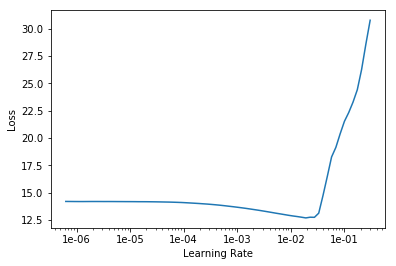

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(4, 1e-3)

epoch,train_loss,valid_loss,time
0,6.183660,7.437054,21:21
1,5.517251,6.377806,19:53
2,5.264047,6.305460,20:19
3,4.947694,5.875203,20:33


Let's free up some RAM

In [0]:
del de_vecs
del en_vecs

As loss is not very interpretable, let's also look at the accuracy.  Again, we will add padding so that the output and target are of the same length.

In [0]:
def seq2seq_acc(out, targ, pad_idx=1):
    bs,targ_len = targ.size()
    _,out_len,vs = out.size()
    if targ_len>out_len: out  = F.pad(out,  (0,0,0,targ_len-out_len,0,0), value=pad_idx)
    if out_len>targ_len: targ = F.pad(targ, (0,out_len-targ_len,0,0), value=pad_idx)
    out = out.argmax(2)
    return (out==targ).float().mean()

### Bleu metric

In [0]:
class NGram():
    def __init__(self, ngram, max_n=5000): self.ngram,self.max_n = ngram,max_n
    def __eq__(self, other):
        if len(self.ngram) != len(other.ngram): return False
        return np.all(np.array(self.ngram) == np.array(other.ngram))
    def __hash__(self): return int(sum([o * self.max_n**i for i,o in enumerate(self.ngram)]))

In [0]:
def get_grams(x, n, max_n=5000):
    return x if n==1 else [NGram(x[i:i+n], max_n=max_n) for i in range(len(x)-n+1)]

In [0]:
def get_correct_ngrams(pred, targ, n, max_n=5000):
    pred_grams,targ_grams = get_grams(pred, n, max_n=max_n),get_grams(targ, n, max_n=max_n)
    pred_cnt,targ_cnt = Counter(pred_grams),Counter(targ_grams)
    return sum([min(c, targ_cnt[g]) for g,c in pred_cnt.items()]),len(pred_grams)

In [0]:
class CorpusBLEU(Callback):
    def __init__(self, vocab_sz):
        self.vocab_sz = vocab_sz
        self.name = 'bleu'
    
    def on_epoch_begin(self, **kwargs):
        self.pred_len,self.targ_len,self.corrects,self.counts = 0,0,[0]*4,[0]*4
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        last_output = last_output.argmax(dim=-1)
        for pred,targ in zip(last_output.cpu().numpy(),last_target.cpu().numpy()):
            self.pred_len += len(pred)
            self.targ_len += len(targ)
            for i in range(4):
                c,t = get_correct_ngrams(pred, targ, i+1, max_n=self.vocab_sz)
                self.corrects[i] += c
                self.counts[i]   += t
    
    def on_epoch_end(self, last_metrics, **kwargs):
        precs = [c/t for c,t in zip(self.corrects,self.counts)]
        len_penalty = exp(1 - self.targ_len/self.pred_len) if self.pred_len < self.targ_len else 1
        bleu = len_penalty * ((precs[0]*precs[1]*precs[2]*precs[3]) ** 0.25)
        return add_metrics(last_metrics, bleu)

### Training with metrics

In [0]:
learn = Learner(data, rnn, loss_func=seq2seq_loss, metrics=[seq2seq_acc, CorpusBLEU(len(data.y.vocab.itos))])

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


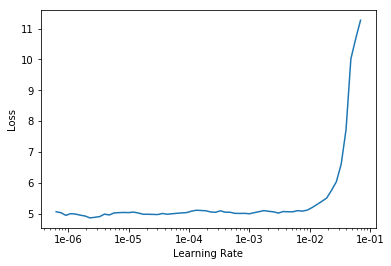

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(4, 1e-4)

epoch,train_loss,valid_loss,seq2seq_acc,bleu,time
0,4.867053,5.825262,0.247242,0.167211,21:24
1,4.874644,5.845784,0.245721,0.166316,21:33
2,4.813367,5.695110,0.257717,0.174171,21:18
3,4.598033,5.671896,0.259412,0.175585,21:31


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in long_scalars
  


Let's see a few predictions.

In [0]:
def get_predictions(learn, ds_type=DatasetType.Valid):
    learn.model.eval()
    inputs, targets, outputs = [],[],[]
    with torch.no_grad():
        for xb,yb in progress_bar(learn.dl(ds_type)):
            out = learn.model(xb)
            for x,y,z in zip(xb,yb,out):
                inputs.append(learn.data.train_ds.x.reconstruct(x))
                targets.append(learn.data.train_ds.y.reconstruct(y))
                outputs.append(learn.data.train_ds.y.reconstruct(z.argmax(1)))
    return inputs, targets, outputs

In [0]:
inputs, targets, outputs = get_predictions(learn)

In [0]:
inputs[700], targets[700], outputs[700]

(Text xxbos trump ’s simplistic , xenophobic rhetoric will also find a sympathetic audience among poles and hungarians who fear large - scale immigration .,
 Text xxbos trumps vereinfachende , xxunk rhetorik wird auch bei jenen polen und ungarn anklang finden , die sich vor umfangreicher zuwanderung fürchten .,
 Text xxbos trumps xxunk xxunk xxunk , , , , , , , , und und und und xxunk xxunk . .)

In [0]:
inputs[701], targets[701], outputs[701]

(Text xxbos my portal to the world of artificial intelligence is a narrow one : the more than xxunk - old game of chess .,
 Text xxbos mein eigener zugang zur welt der künstlichen intelligenz ist ein eng xxunk : das über 500 jahre alte xxunk schach .,
 Text xxbos ich der der der der der der der der xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk)

In [0]:
inputs[2000], targets[2000], outputs[2000]

(Text xxbos the transition from autocracy to democracy in the middle east is likely to be bumpy and unstable , at best .,
 Text xxbos der übergang von der autokratie zur demokratie i m nahen osten wird wahrscheinlich holprig und instabil verlaufen – bestenfalls .,
 Text xxbos der der der nahen osten osten osten osten osten osten osten osten und und und osten . .)

In [0]:
inputs[2513], targets[2513], outputs[2513]

(Text xxbos but it is time to go further and begin to lobby aggressively for faster financial liberalization in the developing world .,
 Text xxbos es ist allerdings an der zeit , sich darüber hinaus mit mehr nachdruck für eine raschere finanzliberalisierung in den entwicklungsländern einzusetzen .,
 Text xxbos aber es es zeit zeit , , , , die die die die in in zu zu zu .)

It's usually beginning well, but falls into repeated words at the end of the question.

## Teacher forcing

One way to help training is to help the decoder by feeding it the real targets instead of its predictions (if it starts with wrong words, it's very unlikely to give us the right translation). We do that all the time at the beginning, then progressively reduce the amount of teacher forcing.

In [0]:
class TeacherForcing(LearnerCallback):
    
    def __init__(self, learn, end_epoch):
        super().__init__(learn)
        self.end_epoch = end_epoch
    
    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        if train: return {'last_input': [last_input, last_target]}
    
    def on_epoch_begin(self, epoch, **kwargs):
        self.learn.model.pr_force = 1 - epoch/self.end_epoch

We will add the following code to our `forward` method:

```
    if (targ is not None) and (random.random()<self.pr_force):
        if i>=targ.shape[1]: break
        dec_inp = targ[:,i]
```
Additionally, `forward` will take an additional argument of `target`.

In [0]:
class Seq2SeqRNN_tf(nn.Module):
    def __init__(self, emb_enc, emb_dec, nh, out_sl, nl=2, bos_idx=0, pad_idx=1):
        super().__init__()
        self.nl,self.nh,self.out_sl = nl,nh,out_sl
        self.bos_idx,self.pad_idx = bos_idx,pad_idx
        self.em_sz_enc = emb_enc.embedding_dim
        self.em_sz_dec = emb_dec.embedding_dim
        self.voc_sz_dec = emb_dec.num_embeddings
                 
        self.emb_enc = emb_enc
        self.emb_enc_drop = nn.Dropout(0.15)
        self.gru_enc = nn.GRU(self.em_sz_enc, nh, num_layers=nl,
                              dropout=0.25, batch_first=True)
        self.out_enc = nn.Linear(nh, self.em_sz_dec, bias=False)
        
        self.emb_dec = emb_dec
        self.gru_dec = nn.GRU(self.em_sz_dec, self.em_sz_dec, num_layers=nl,
                              dropout=0.1, batch_first=True)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(self.em_sz_dec, self.voc_sz_dec)
        self.out.weight.data = self.emb_dec.weight.data
        self.pr_force = 0.
        
    def encoder(self, bs, inp):
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        _, h = self.gru_enc(emb, h)
        h = self.out_enc(h)
        return h
    
    def decoder(self, dec_inp, h):
        emb = self.emb_dec(dec_inp).unsqueeze(1)
        outp, h = self.gru_dec(emb, h)
        outp = self.out(self.out_drop(outp[:,0]))
        return h, outp
            
    def forward(self, inp, targ=None):
        bs, sl = inp.size()
        h = self.encoder(bs, inp)
        dec_inp = inp.new_zeros(bs).long() + self.bos_idx
        
        res = []
        for i in range(self.out_sl):
            h, outp = self.decoder(dec_inp, h)
            res.append(outp)
            dec_inp = outp.max(1)[1]
            if (dec_inp==self.pad_idx).all(): break
            if (targ is not None) and (random.random()<self.pr_force):
                if i>=targ.shape[1]: continue
                dec_inp = targ[:,i]
        return torch.stack(res, dim=1)

    def initHidden(self, bs): return one_param(self).new_zeros(self.nl, bs, self.nh)

In [0]:
emb_enc = torch.load(path_translation + 'en_emb_137k_25l.pth')
emb_dec = torch.load(path_translation + 'de_emb_137k_25l.pth')

In [0]:
data = load_data(path_translation_data, "db1_137k_25sl")

In [0]:
rnn_tf = Seq2SeqRNN_tf(emb_enc, emb_dec, 256, 30)

learn_tf = Learner(data, rnn_tf, loss_func=seq2seq_loss, metrics=[seq2seq_acc, CorpusBLEU(len(data.y.vocab.itos))],
               callback_fns=partial(TeacherForcing, end_epoch=3))

In [0]:
learn_tf.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


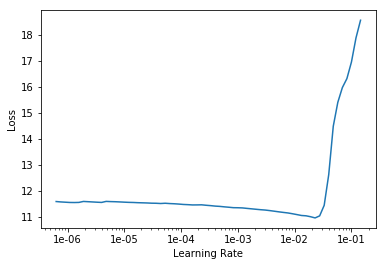

In [0]:
learn_tf.recorder.plot()

I'm trying out a few different learning rates here. The loss/learning rate curve is not easily interpretable, so we need to experiment a bit.

In [0]:
learn_tf.fit_one_cycle(3, 1e-4)

epoch,train_loss,valid_loss,seq2seq_acc,bleu,time
0,5.243083,4.877440,0.413164,0.181102,30:06
1,4.608022,5.998855,0.248835,0.171576,24:17
2,5.079815,6.600609,0.206655,0.153055,21:30


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in long_scalars
  


In [0]:
learn_tf.fit_one_cycle(4, 5e-4)

epoch,train_loss,valid_loss,seq2seq_acc,bleu,time
0,4.086277,6.145834,0.334220,0.215677,28:27
1,3.992745,5.950576,0.263096,0.201561,23:12
2,4.293686,6.328215,0.222104,0.174188,22:17
3,5.323520,6.390608,0.216423,0.152178,20:43


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in long_scalars
  


In [0]:
learn_tf.fit_one_cycle(4, 8e-4)

epoch,train_loss,valid_loss,seq2seq_acc,bleu,time
0,3.704269,5.146167,0.352601,0.134110,24:37
1,3.517701,6.070536,0.261921,0.219345,23:59
2,4.184779,6.034648,0.242406,0.187292,23:15
3,4.939337,6.043734,0.240516,0.165269,21:56


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in long_scalars
  


In [0]:
hlearn_tf.fit_one_cycle(4, 1e-3)

epoch,train_loss,valid_loss,seq2seq_acc,bleu,time
0,3.708332,6.911163,0.273896,0.218682,27:21
1,3.606237,5.657241,0.284641,0.214021,23:38
2,3.905083,5.947309,0.248738,0.192882,23:03
3,4.866989,6.014758,0.242266,0.165167,20:45


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in long_scalars
  


With Teacher's Forcing we can improve our Bleu scores to ~0.21. Our outputs with TF (below) are bit better but still far from acceptable. 

In [0]:
inputs, targets, outputs = get_predictions(learn_tf)

In [0]:
inputs[700],targets[700],outputs[700]

(Text xxbos trump ’s simplistic , xenophobic rhetoric will also find a sympathetic audience among poles and hungarians who fear large - scale immigration .,
 Text xxbos trumps vereinfachende , xxunk rhetorik wird auch bei jenen polen und ungarn anklang finden , die sich vor umfangreicher zuwanderung fürchten .,
 Text xxbos trumps xxunk xxunk xxunk , , , xxunk xxunk und , , , , und und xxunk xxunk .)

In [0]:
inputs[701],targets[701],outputs[701]

(Text xxbos my portal to the world of artificial intelligence is a narrow one : the more than xxunk - old game of chess .,
 Text xxbos mein eigener zugang zur welt der künstlichen intelligenz ist ein eng xxunk : das über 500 jahre alte xxunk schach .,
 Text xxbos meine xxunk der der der der ist ist ein , , , , xxunk xxunk xxunk xxunk .)

In [0]:
inputs[2000], targets[2000], outputs[2000]

(Text xxbos the transition from autocracy to democracy in the middle east is likely to be bumpy and unstable , at best .,
 Text xxbos der übergang von der autokratie zur demokratie i m nahen osten wird wahrscheinlich holprig und instabil verlaufen – bestenfalls .,
 Text xxbos der kampf der der in in in osten in osten ist und und und und und .)

In [0]:
inputs[2513], targets[2513], outputs[2513]

(Text xxbos but it is time to go further and begin to lobby aggressively for faster financial liberalization in the developing world .,
 Text xxbos es ist allerdings an der zeit , sich darüber hinaus mit mehr nachdruck für eine raschere finanzliberalisierung in den entwicklungsländern einzusetzen .,
 Text xxbos es ist es zeit zeit , , , und , die die die die die die der zu)